In [171]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Raw Code"></form>''')

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wrangle import *

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from math import sqrt

from scipy import stats
from pydataset import data

import warnings
warnings.filterwarnings("ignore")

df = wrangle_zillow()
target = 'tax_valuedollar_count'

Reading CSV


# Zillow Property Value

## Goal

Find drivers of property value

Find best peforming model to predict property value.

### README
`README.md` @ GitHub

### Modules
#### `env.py`
###### ** SQL Credentials
###### ** get_db_url()

#### `wrangle.py`
###### ** get_data()
###### ** target_data()
###### ** split_data()
###### ** clean_data()

## Acquire
###### - SQL Credentials
###### - get_db_url()
###### - get_data()

From Codeup SQL Database

Initial SQL Dataset was 52,441 Rows, 62 Columns

Working Dataset was 50,673 Rows, 29 Columns

Each row is a house sold in 2017 Single Family Home

## Prepare
###### - clean_data()

### `target = tax_valuedollar_count`

Initial Dataset had 33 columns with over 35% null values.

Null value columns were dropped.

Second round of filtering found 13 columns with less than 1% null values.

Null value rows were dropped.

Renamed columns using Python naming coventions.

## Explore

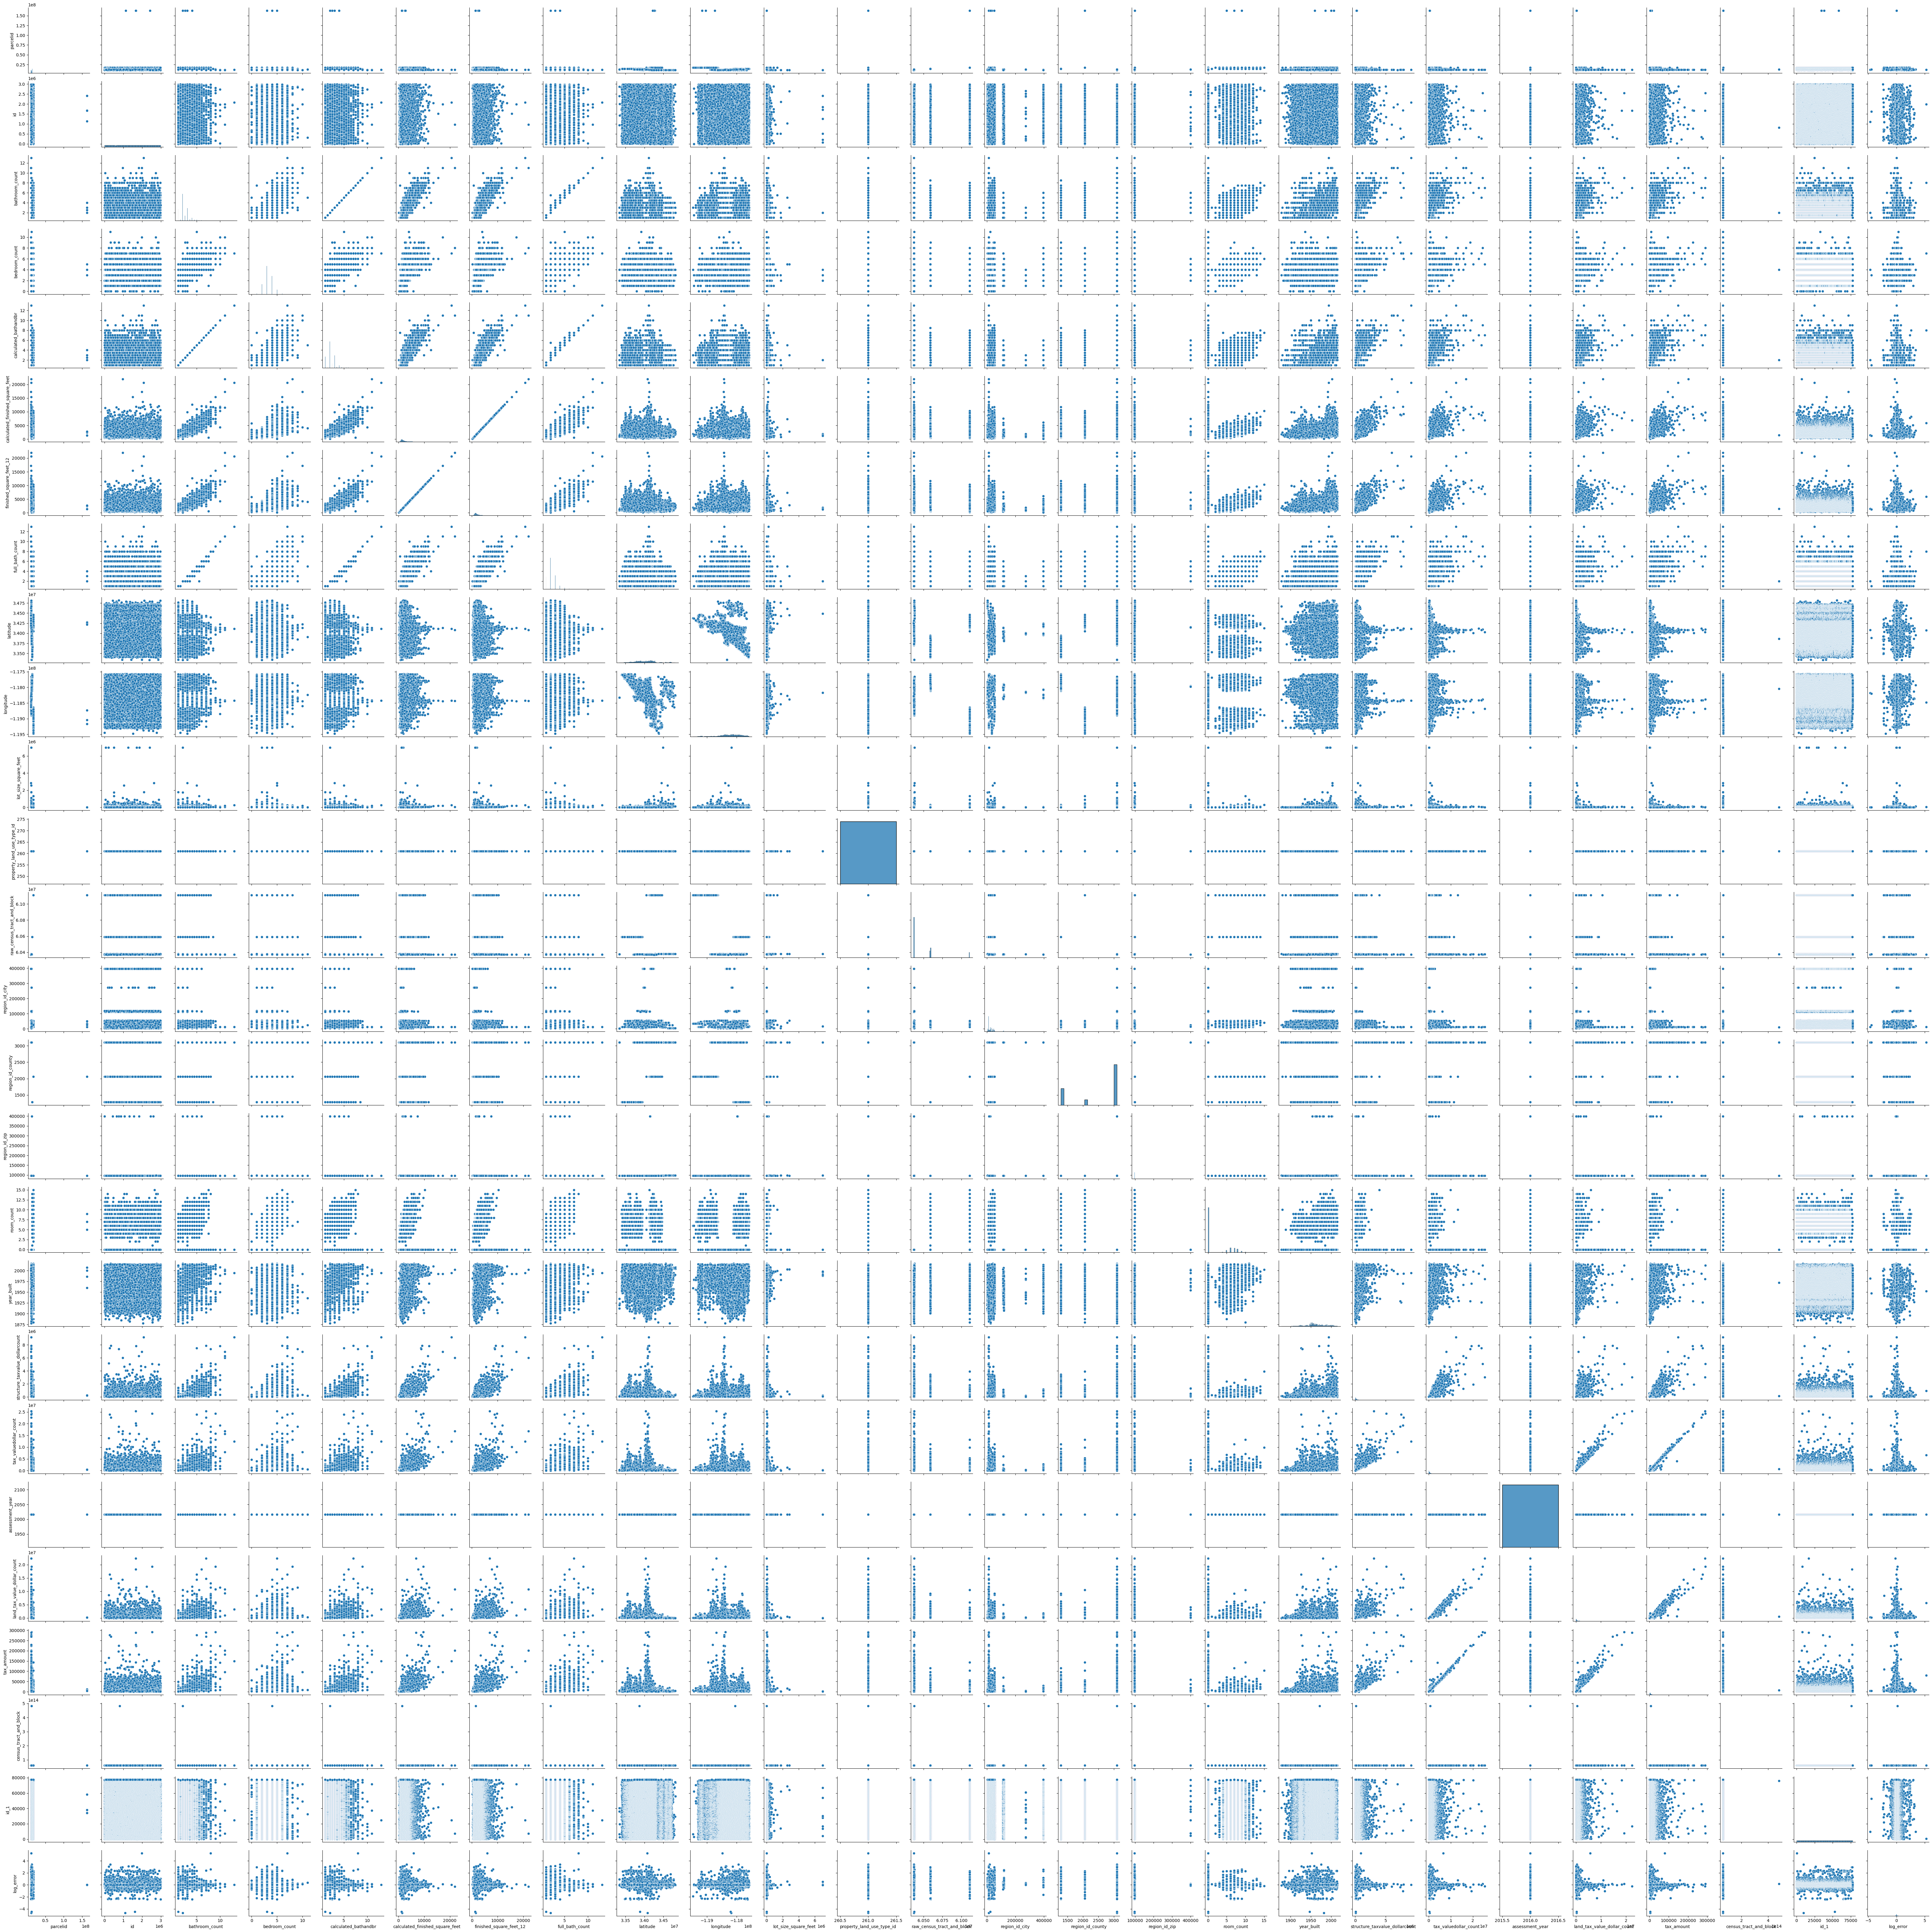

In [3]:
sns.pairplot(df)

### 1. Does total count of bedrooms and bathrooms affect property value?

${H_0}$: There is no **linear** relationship between bathroom_count and tax_valuedollar_count

${H_a}$: There is a **linear** relationship between bathroom_count and tax_valuedollar_count

In [7]:
group1 = 'bed_bath_count'
group2 = target

In [8]:
r,p = stats.pearsonr(df[group1],df[group2])

In [9]:
alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [10]:
eval_results(p, alpha, group1, group2)

'There exists some relationship between bed_bath_count and tax_valuedollar_count. (p-value: 0.0000)'

Text(8, 80, 'r = 0.452')

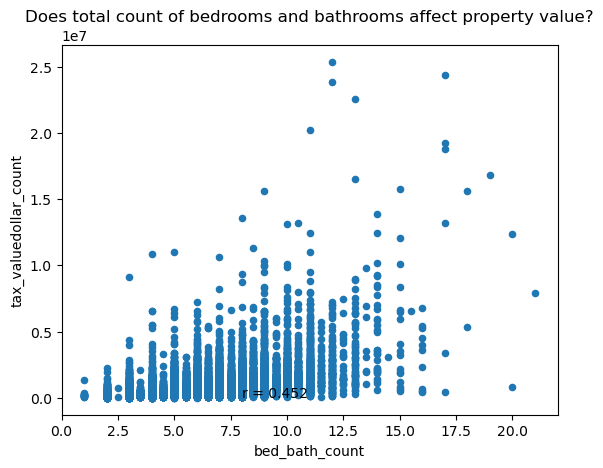

In [11]:
df.plot.scatter('bed_bath_count', 'tax_valuedollar_count')
plt.title('Does total count of bedrooms and bathrooms affect property value?')
plt.text(8, 80, f'r = {r:.3f}')

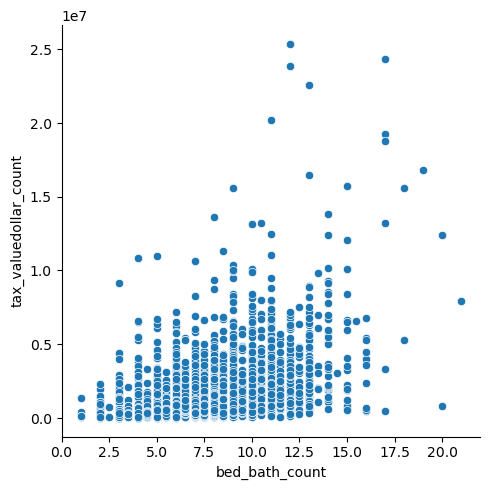

In [6]:
sns.relplot(data=df, y='tax_valuedollar_count', x='bed_bath_count')

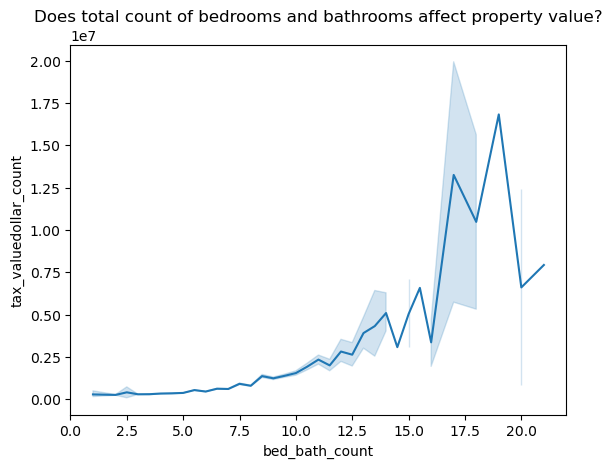

In [8]:
sns.lineplot(data=df, x='bed_bath_count', y='tax_valuedollar_count')
plt.title('Does total count of bedrooms and bathrooms affect property value?')
plt.xlabel('bed_bath_count')
plt.ylabel('tax_valuedollar_count')
plt.show()

### 2. Does  `calculated_finished_square_feet` affect `tax_valuedollar_count`?

In [12]:
group1 = 'calculated_finished_square_feet'
group2 = 'tax_valuedollar_count'

${H_0}$: There is no **linear** relationship between `calculated_finished_square_feet` and `tax_valuedollar_count`

${H_a}$: There is a **linear** relationship between `calculated_finished_square_feet` and `tax_valuedollar_count`

In [13]:
r,p = stats.pearsonr(df[group1], df[group2])

In [14]:
alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [15]:
eval_results(p, alpha, group1, group2)

'There exists some relationship between calculated_finished_square_feet and tax_valuedollar_count. (p-value: 0.0000)'

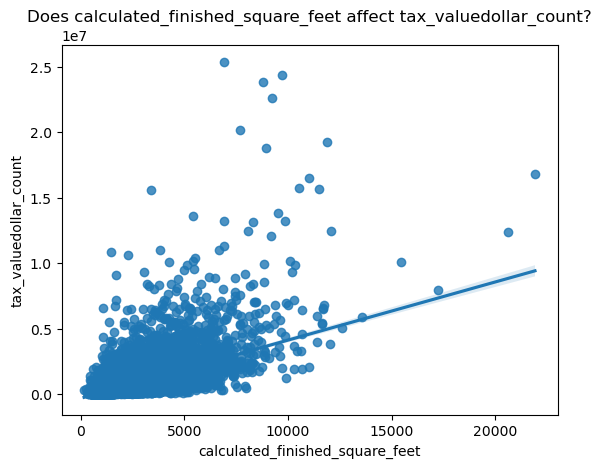

In [90]:
sns.regplot(data=df, x=group1, y=group2)
plt.title('Does calculated_finished_square_feet affect tax_valuedollar_count?')
plt.xlabel(f'{group1}')
plt.ylabel(f'{group2}')
plt.show()

### 3. Does `year_built` affect `tax_valuedollar_count`?

In [16]:
group1 = 'year_built'
group2 = 'tax_valuedollar_count'

${H_0}$: There is no **linear** relationship between year_built and tax_valuedollar_count

${H_a}$: There is a **linear** relationship between year_built and tax_valuedollar_count

In [17]:
t, p = stats.ttest_ind(df[group1], df[group2])
t, p / 2
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We fail to reject $H_{0}$


In [18]:
eval_results(p, alpha, group1, group2)

'There exists some relationship between year_built and tax_valuedollar_count. (p-value: 0.0000)'

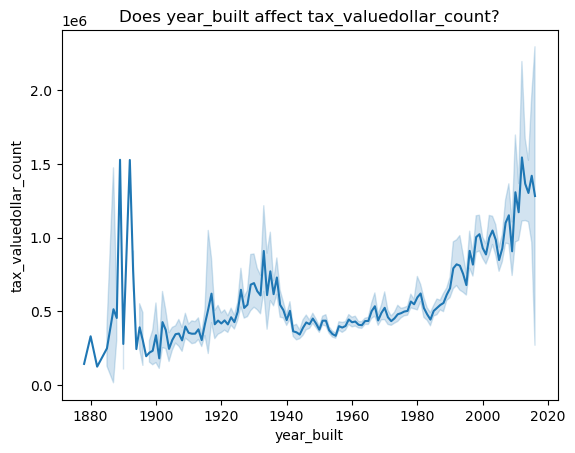

In [21]:
sns.lineplot(data=df, x=group1, y=group2)
plt.title('Does year_built affect tax_valuedollar_count?')
plt.xlabel('year_built')
plt.ylabel('tax_valuedollar_count')
plt.show()

<div class="alert alert-block alert-success">

<b>Takeaways</b>
    
In my exploration phase I found statistcally significant drives of property value like year_built, room_count, and square_ftg.
</div> 

<hr style="border:2px solid gray">

## Modeling
###### - model_data()
- Isolate Target
###### - split_data()
- Train, Val, Test
###### - scale_data()
- Scale for Modeling

In [46]:
continous = ['calculated_finished_square_feet'\
             ,'finished_square_feet_12'\
             ,'latitude'\
             ,'longitude']

In [47]:
discrete = ['year_built','assessment_year','bed_bath_count','full_bath_count'\
            ,'bathroom_count'\
            ,'bedroom_count'\
           ,'fips']

In [48]:
model = df[continous]
model[discrete]=df[discrete]
model[target]=df[target]
model.shape

(50673, 12)

In [57]:
train,val,test = split_data(model)

In [58]:
train.shape

(38004, 12)

# Isolate Target

In [59]:
# Train X,y
train_X,train_y = model_data(train,target)

# Val X,y
val_X,val_y = model_data(val,target)

# Test X,y
test_X,test_y = model_data(test,target)

In [60]:
train_X.shape,train_y.shape

((38004, 11), (38004,))

In [61]:
# Train Scaled
#train_X_scaled = pd.DataFrame(train_X[continous])
train_X_scaled[continous] = MinMaxScaler(train_X_scaled[continous])

# Val Scaled
#val_X_scaled = pd.DataFrame(val_X[continous])
val_X_scaled[continous] = MinMaxScaler(val_X_scaled[continous])

# Test Scaled
#test_X_scaled = pd.DataFrame(test_X[continous])
test_X_scaled[continous] = MinMaxScaler(test_X_scaled[continous])

In [68]:
# Train Dummies
train_X_scaled[discrete] = train_X[discrete]
train_X_scaled = pd.get_dummies(train_X_scaled[discrete])

# Val Dummies
val_X_scaled[discrete] = val_X[discrete]
val_X_scaled = pd.get_dummies(val_X_scaled[discrete])

# Test Dummies
test_X_scaled[discrete] = test_X[discrete]
test_X_scaled = pd.get_dummies(test_X_scaled[discrete])

In [74]:
train_X_scaled.shape

(38004, 9)

In [71]:
val_X_scaled.shape

(12669, 9)

In [72]:
test_X_scaled.shape

(10135, 9)

In [80]:
f_selector = SelectKBest(f_regression, k=2)

f_selector.fit(train_X_scaled, train_y)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()
f_feature = train_X_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['full_bath_count', 'bathroom_count']

In [83]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(train_X_scaled, train_y)

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = train_X_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['bed_bath_count', 'bedroom_count']

In [85]:
var_ranks = rfe.ranking_

# get the variable names
var_names = train_X_scaled.columns.tolist()

# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

# sort the df by rank
rfe_ranks_df.sort_values('Rank').head(3)

Var  Rank
2  bed_bath_count     1
5   bedroom_count     1
4  bathroom_count     2

In [88]:
# Baseline
preds = pd.DataFrame({'actual': train_y})
preds['baseline'] = train_y.mean()

In [108]:
print(f"Baseline RMSE = {(sqrt(mean_squared_error(preds['actual'], preds['baseline'])))}")

Baseline RMSE = 716375.0002321043


In [114]:
# Lasso Model
lasso = LassoLars(alpha=.1)
lasso.fit(train_X, train_y)
preds['lasso']= lasso.predict(train_X)

In [115]:
# Lasso RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['lasso']))

542493.3682668867

In [112]:
# Linear Model
lm = LinearRegression()
lm.fit(train_X, train_y)
preds['linear'] = lm.predict(train_X)

In [113]:
# Linear RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['linear']))

542493.3630272637

In [117]:
# Tweedie Model
tweedie = TweedieRegressor(power=0)
tweedie.fit(train_X, train_y)
preds['tweedie'] = tweedie.predict(train_X)

In [118]:
# Tweedie RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['tweedie']))

550794.5933445203

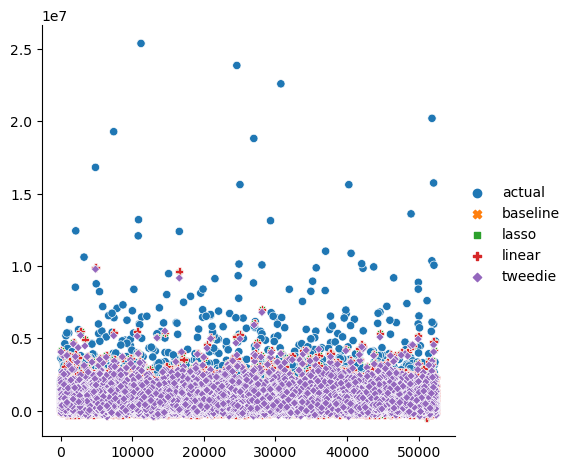

In [170]:
sns.relplot(preds)

<AxesSubplot: >

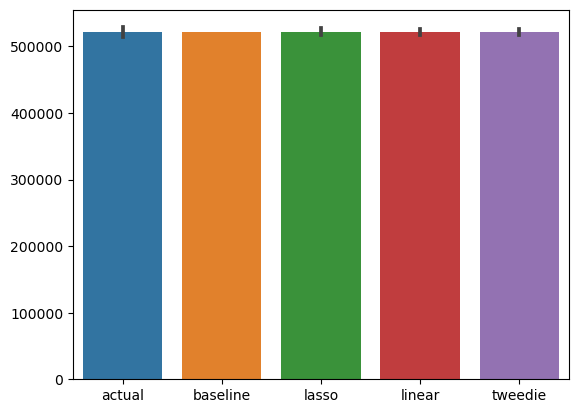

In [169]:
sns.barplot(preds)

<div class="alert alert-block alert-success">

<b>Takeaways</b>
    
Best performing models was Tweedie Model. Other Models were not far off but all very similar.

</div> 

<hr style="border:2px solid gray">

## Test

In [120]:
# Baseline
test_preds = pd.DataFrame({'actual': test_y})
test_preds['baseline'] = test_y.mean()

In [121]:
# Tweedie Model
tweedie = TweedieRegressor(power=0)
tweedie.fit(test_X, test_y)
test_preds['tweedie_test'] = tweedie.predict(test_X)

In [122]:
# Tweedie RMSE Metric
sqrt(mean_squared_error(test_preds['actual'], test_preds['tweedie_test']))

549109.8429938578

In [123]:
test_preds

actual       baseline   tweedie_test
7914    396337.0  523997.845091  429333.061702
2528    263328.0  523997.845091  253309.730922
27568   177723.0  523997.845091  456382.037369
32993    91701.0  523997.845091  628200.266697
39697   327117.0  523997.845091  309041.857777
...          ...            ...            ...
50241   511105.0  523997.845091  687869.322327
2237    558387.0  523997.845091  345094.829864
46499   618940.0  523997.845091  722801.367973
22435  1016324.0  523997.845091  713973.118822
52067   232204.0  523997.845091  827413.468613

[10135 rows x 3 columns]

In [163]:
test = {'test_tweedie' : [test_tweedie],'test_baseline' : [test_baseline]}

In [ ]:
details = {
    'Name' : ['Ankit', 'Aishwarya', 'Shaurya', 'Shivangi'],
    'Age' : [23, 21, 22, 21],
    'University' : ['BHU', 'JNU', 'DU', 'BHU'],
}

In [164]:
test

{'test_tweedie': [549109.8429938578], 'test_baseline': [728521.7798801082]}

In [165]:
test_model_metrics=pd.DataFrame(test)

In [159]:
test_tweedie = sqrt(mean_squared_error(test_preds['actual'], test_preds['tweedie_test']))
test_baseline = sqrt(mean_squared_error(test_preds['actual'], test_preds['baseline']))

In [149]:
test_model_metrics["test_tweedie"] = test_tweedie

In [166]:
test_model_metrics

test_tweedie  test_baseline
0  549109.842994   728521.77988

<AxesSubplot: >

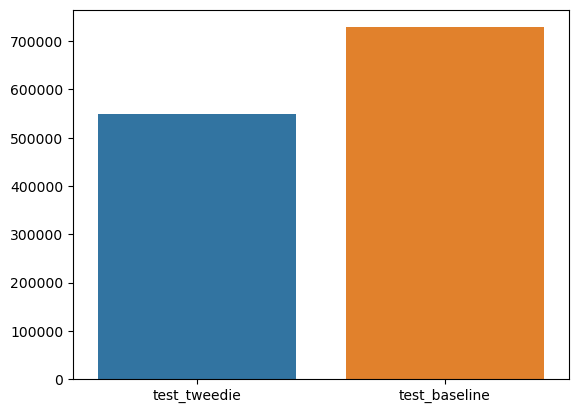

In [168]:
sns.barplot(test_model_metrics)

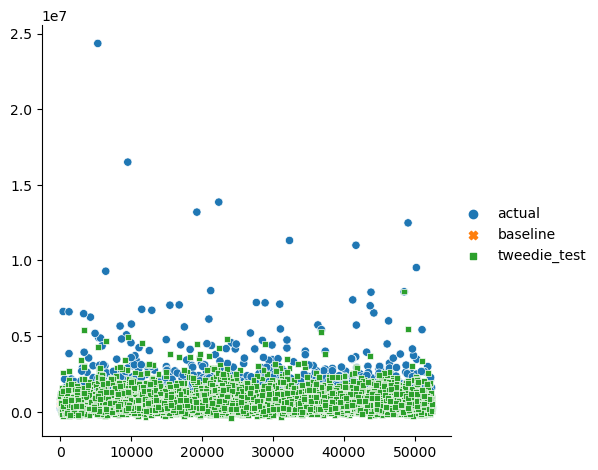

In [127]:
sns.relplot(test_preds)

<div class="alert alert-block alert-success">

<b>Takeaways</b>
    
The tweedie regression model is able to out-perform the baseline with an RMSE of 549,109 vs 728,521

</div> 

<hr style="border:2px solid gray">

## Summary

The biggest factors appear to be the square footage of the house, as well as the number of bedrooms and bathrooms.


#### Takeaways

Square Footage, bedrooms & bathroom count are correlated to tax_value

The tweedie regression model is able to out-perform the baseline with an RMSE of 549,109 vs 728,521


#### Recommendations
The higher the value of square footage and room count the more likely the proper is to have greater tax value.

Targeting single family homes that deviate on the high end with these features.

Create new metrics for dataset using new customer shopping criteria.

#### Next Steps:

Advanced feature engineering by combinding features.

Use for loop comparing combination of models to evaluate peformance with different features.
